# Tutorial 10a: Colocalization

*This tutorial was generated from a Jupyter notebook.  You can download the notebook [here](t10a_colocalization.ipynb).*

In [31]:
import os
import random
import warnings

# Our numerical workhorses
import numpy as np
import scipy.stats as st

# BE/Bi 103 utilities
import bebi103

# Image processing tools
import skimage.io
import skimage.filters
import skimage.morphology

# Import plotting tools
import matplotlib.pyplot as plt
import seaborn as sns

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables high res graphics inline (only use with static plots (non-Bokeh))
# SVG is preferred, but there is a bug in Jupyter with vertical lines
%config InlineBackend.figure_formats = {'png', 'retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style('darkgrid', rc=rc)

# Suppress future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In this tutorial, we will learn about **colocalization**.  In a colocalization study, we seek to answer the question: Are two fluorescent proteins spatially proximal in a cell?  You can download the data set [here](http://bebi103.caltech.edu/2015/data/webster_et_al.zip).  You should also be sure to have updated your [BE/Bi 103 utilities](https://github.com/justinbois/bebi103_utils).  We will do colocalization using the [Costes method](http://bebi103.caltech.edu/2015/protected/papers/costes_2004.pdf).

## The data set

Data set comes from Alex Webster in Alexei Aravin's lab.  The researchers we investigating the localization of piwi proteins to structures called nuage granules surrounding the nuclei in germ cells.  These piwi proteins serve to post-transcriptionally silence retrotransposons, necessary to maintain the integrity of the germ line.  Two piwi proteins, Aubergine (Aub) and Argonaute-3 (Ago3) are hypothesized to work together in a "ping-pong" mechanism in which they cyclically refine piRNAs to target specific transposable elements.

In the images in this data set, the authors have fluorescently tagged Aubergine with mKate-2.  The have GFP-tagged Zucchini (thought to be a nuclease in piRNA biogenesis), Krimper (a protein present in nuage that can bind both Aub and Ago3), and Tudor (also present in nuage, though with less granularity).  Our goal is to investigate the colocalization of Aubergine with these three proteins.  The images also include a DAPI channel to enable visualization of nuclei.

I encourage you to read the paper, available [here](http://bebi103.caltech.edu/2015/protected/papers/webster_2015.pdf).

## Visualizing colocalization

A commonly used and quick-and-dirty way to visualize colocalization is to merge the channels and look at the images together.  If, say, green and red channels have high intensities at the same place, that location will appear yellow.  As we'll discuss below, this should be done with great caution, and there are better ways to visualize colocalization!

We will start with the Aubergine/Zucchini images.

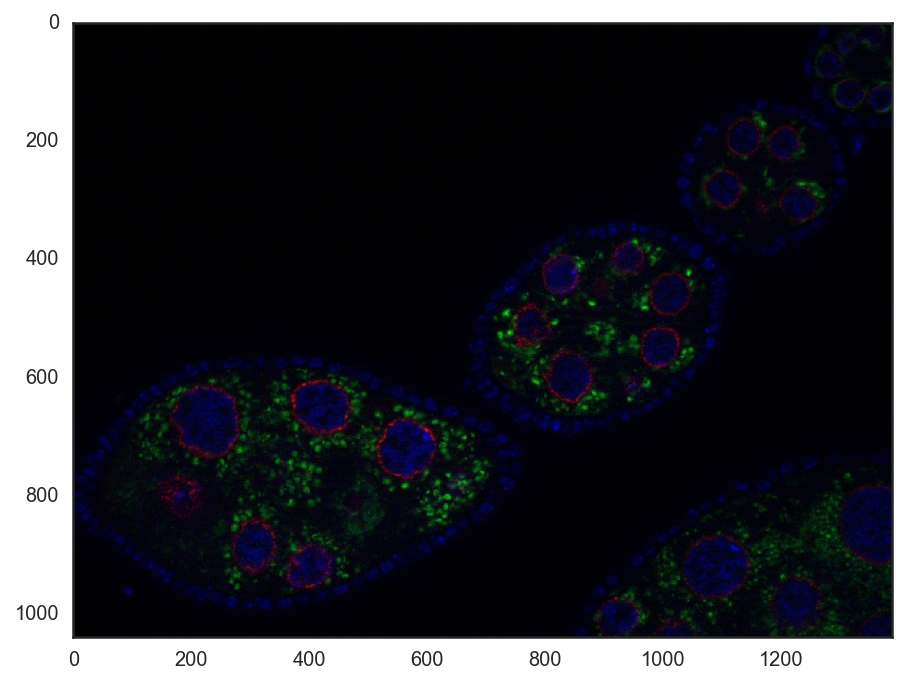

In [32]:
data_dir = '../data/webster_et_al'

# Define file name
fname = os.path.join(data_dir, 'mk2-AubWTxGFP-Zuc_001_40x.TIF')

# Load the image
im = skimage.io.imread(fname)

# Take a look
with sns.axes_style('white'):
    skimage.io.imshow(im)

We see that this is an RGB image, as I have described above.  The blue channel is DAPI so that we can see nuclei, and the channels of interest are the ref channel (Aub) and the green channel (Zucchini).  We can tell by eye that Aubergine and Zucchini are not colocalized; Aubergine is present around the nucleus and Zucchini in puncta throughout the cytoplasm.  Nonetheless, let's perform a careful colocalization analysis to quantify this probability of colocalization.

To start, we need to learn about the image and separate out the channels.

In [33]:
# What data type?
print('Data type:', im.dtype)

# What shape
print('Shape:', im.shape)

Data type: uint8
Shape: (1040, 1388, 3)


We have 1040 $\times$ 1388 8-bit images.  We can slice out the channels we are interested in.

In [34]:
im_r = im[:,:,0]
im_g = im[:,:,1]
im_b = im[:,:,2]

### CMY coloring
We already saw the RGB merge.  This can be a problem for colorblind people, since they cannot distinguish between red and creed.  We can instead code the image to be cyan, magenta, and yellow, corresponding to the R, G, and B channels.  The function `bebi103.im_merge_cmy()` does this for us.

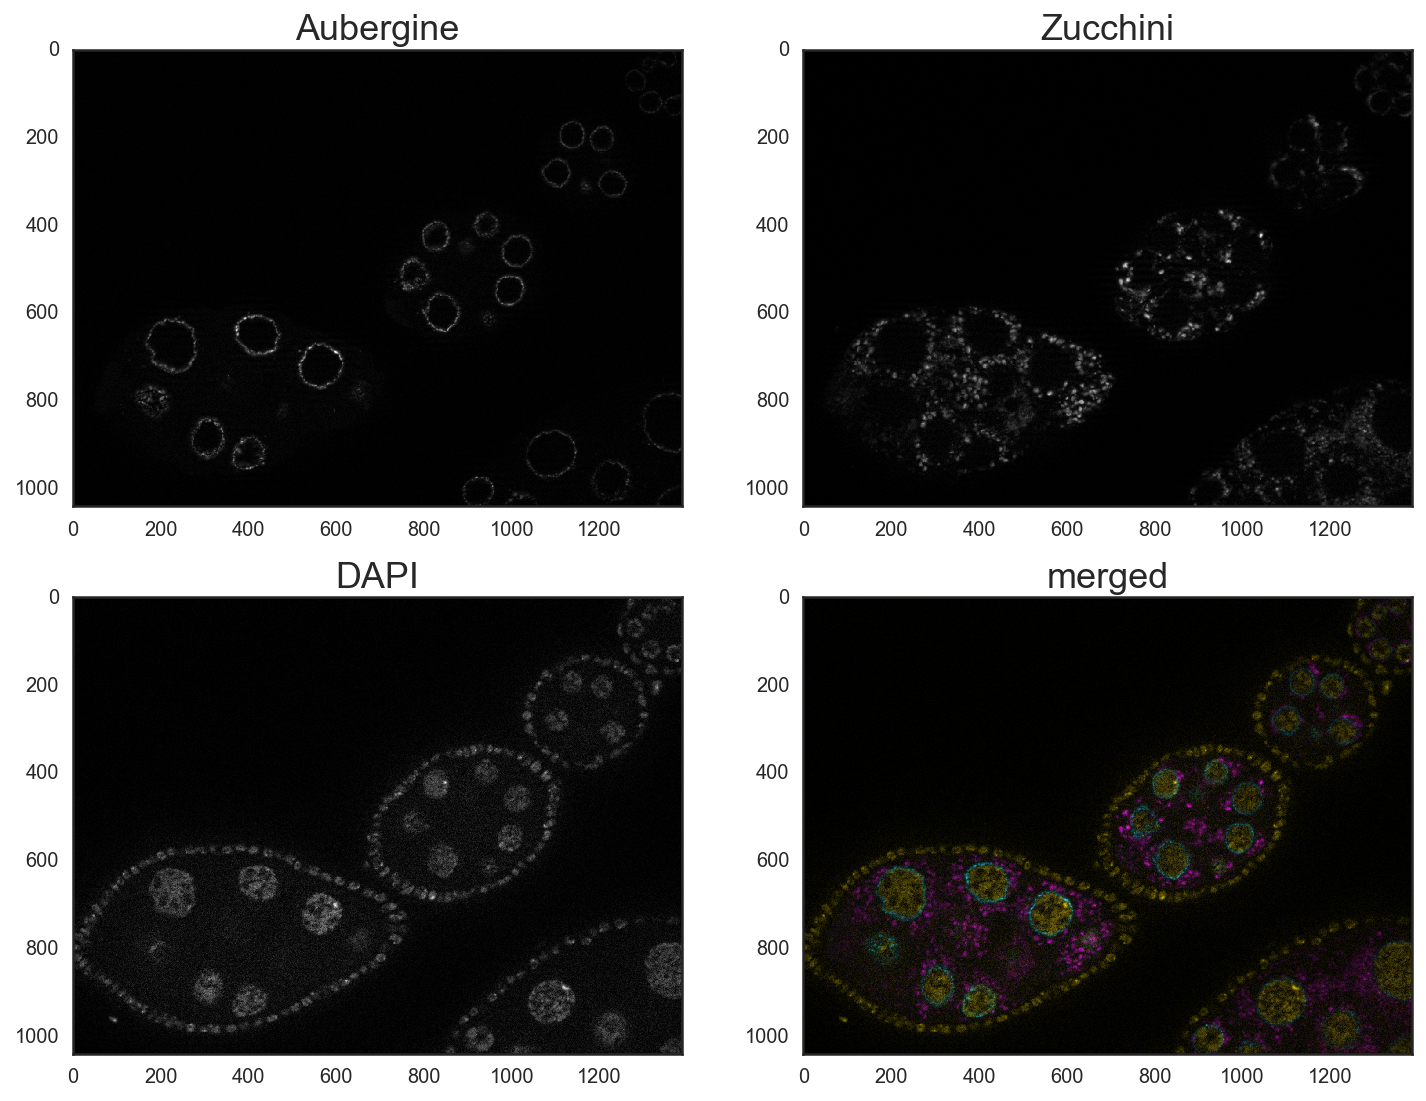

In [35]:
# Make merged image
merged_image = bebi103.im_merge_cmy(im_r, im_g, im_b)

# Show the images
with sns.axes_style('white'):
    figure, ax = plt.subplots(2, 2, figsize=(12, 9))
    ax[0,0].imshow(im_r, cmap=plt.cm.gray)
    ax[0,1].imshow(im_g, cmap=plt.cm.gray)
    ax[1,0].imshow(im_b, cmap=plt.cm.gray)
    ax[1,1].imshow(merged_image)

    ax[0,0].set_title('Aubergine')
    ax[0,1].set_title('Zucchini')
    ax[1,0].set_title('DAPI')
    ax[1,1].set_title('merged')

## Quantifying colocalization

There are many ways to quantify colocalization.  We will try a number of things, eventually landing on the [Costes method](http://bebi103.caltech.edu/2014/protected/papers/costes_2004.pdf) with ROIs.

### 2D histograms

To start our quantification, we "plot" our image in a different way.  On the $x$-axis is pixel values in the red (Aub) channel.  On the $y$-axis is pixel values for the green (Zuc) channel.  We then plot each pixel as a point on these axes.  This is often called a 2D-histogram.  That name is more appropriate when we color the plotted pixels according to counts, which we will not do here for simplicity.

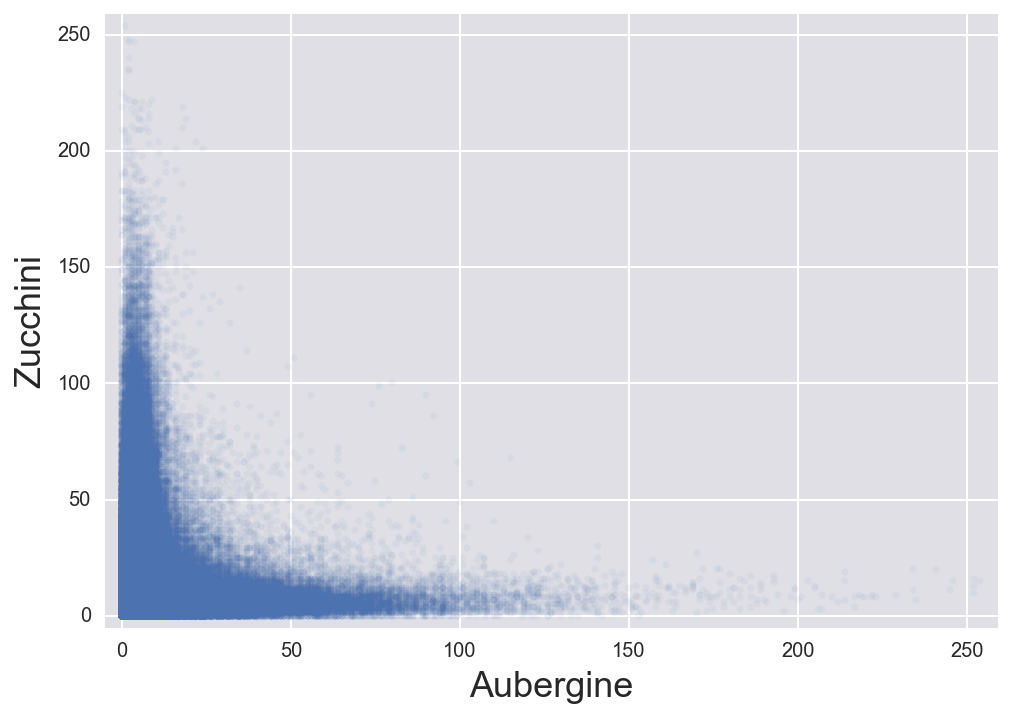

In [36]:
# Plot 2D histogram
plt.plot(im_r.ravel(), im_g.ravel(), '.', alpha=0.05)
plt.xlabel('Aubergine')
plt.ylabel('Zucchini')
plt.margins(0.02)

The lower right corner of this plot is the low-intensity pixels.  A signature of colocalization is lots of pixels in the upper right corner. Large number of pixels in the other corners are a signature of exclusion.  So, the histogram tells us that there is likely not colocalization.  But, we still need to quantify it!

### ICCB analysis

ICCB, or **image correlation coefficient-based** methods for colocalization analysis give a powerful way to quantify colocalization.  The idea is to compute a **correlation coefficient** for the two images.  This should be independent of the absolute scale pixel intensities.  The **Pearson correlation coefficient** works well for this purpose.  For images $I_1$ and $I_2$, it can be computed as

\begin{align}
r = \frac{\sum_i\left(I_{1,i} - \bar{I}_1\right)\left(I_{2,i} - \bar{I}_2\right)}{\sqrt{\left(\sum_i \left(I_{1,i} - \bar{I}_1\right)^2\right)\left(\sum_i \left(I_{2,i} - \bar{I}_2\right)^2\right)}}.
\end{align}

The Pearson $r$ ranges from $-1$ to $1$, where $r = -1$ means exclusion, $r=0$ means independence, and $r=1$ means colocalization.  Fortunately, `scipy.stats.pearsonr()` does the calculation for us!  Let's put this to work!

In [37]:
# Compute Pearson correlation coefficient
r, _ = st.pearsonr(im_r.ravel(), im_g.ravel())

# Print result
print('Pearson r = ', r)

Pearson r =  0.161642674904


Ok.  Pearson $r$ is 0.16.  What does that mean!?  Is it colocalized?  To answer this question, we need a basis for comparison.

## Costes's method

To see if we actually have colocalization, we need to compare the Pearson $r$ to something.  Costes and coworkers proposed repeatedly scrambling one of the images, and then computing the Pearson $r$ between the scrambled image and the original image of the other.  This way, we see if the colocalization is more likely than random chance.

We know that neighboring pixels are not independent of each other because of the finite width of the point spread function.  We therefore should scramble blocks of the image that are the same size of the PSF.  To do this, we first need to make the image have dimensions that are a multiple of the width of the PSF.  We will do this by mirroring the edges of the image.  The function `bebi103.mirror_edges()` does this for us.  When we view the result, we see that we only added a single pixel in each dimension.

In [38]:
# Specify PSF width
psf_width = 3

# Mirror edges
im_r_mirror = bebi103.mirror_edges(im_r, psf_width)
im_g_mirror = bebi103.mirror_edges(im_g, psf_width)

# What is the new shape?
im_r_mirror.shape

(1041, 1389)

Next, we can convert the image to a list of 3$\times$3 (or PSF width $\times$ PSF width) blocks.  The `bebi103.im_to_blocks()` function does this in such that we can also specify an ROI and only keep blocks belonging to the ROI.  We have to remember to use the images with mirrored edges with computing the blocks, since we need the dimensions to be an integer multiple of the PSF width.

In [39]:
# Get blocks of red and green channels
blocks_r = bebi103.im_to_blocks(im_r_mirror, psf_width)
blocks_g = bebi103.im_to_blocks(im_g_mirror, psf_width)

# Store green blocks as flattened array since we don't scramble them
blocks_g_flat = np.array(blocks_g).flatten()

We can compute the Pearson $r$ value from the blocks to verify that it's the same as before (a good bug check).

In [40]:
# Get r value for unscrambled images
r_unscr, p = st.pearsonr(np.array(blocks_r).ravel(), blocks_g_flat)

# Print the value
print('unscrambled r =', r_unscr)

unscrambled r = 0.161681934911


We are off in the fifth decimal place, due to the fact that we used the mirrored images in this calculation and not the original one.

Now we'll scramble the red image and measure the Pearson $r$ value for each scrambled image.  We'll keep it in an array, `r_scr`.

In [11]:
def scrambled_r(n_scramble, blocks_1, blocks_2_flat):
    """
    Scrambles blocks_1 n_scramble times and returns the Pearson r values.
    """
    r_scr = np.empty(n_scramble)
    for i in range(n_scramble):
        random.shuffle(blocks_1)
        r, _ = st.pearsonr(np.array(blocks_1).ravel(), blocks_2_flat)
        r_scr[i] = r
    return r_scr

# Do the scamblin'!
n_scramble = 200
r_scr = scrambled_r(n_scramble, blocks_r, blocks_g_flat)

We can plot the histogram to see what $r$ values we might expect from random pixel locations in the respective images.  We'll plot the observed Pearson r as a vertical line.

/Users/Justin/anaconda/lib/python3.4/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


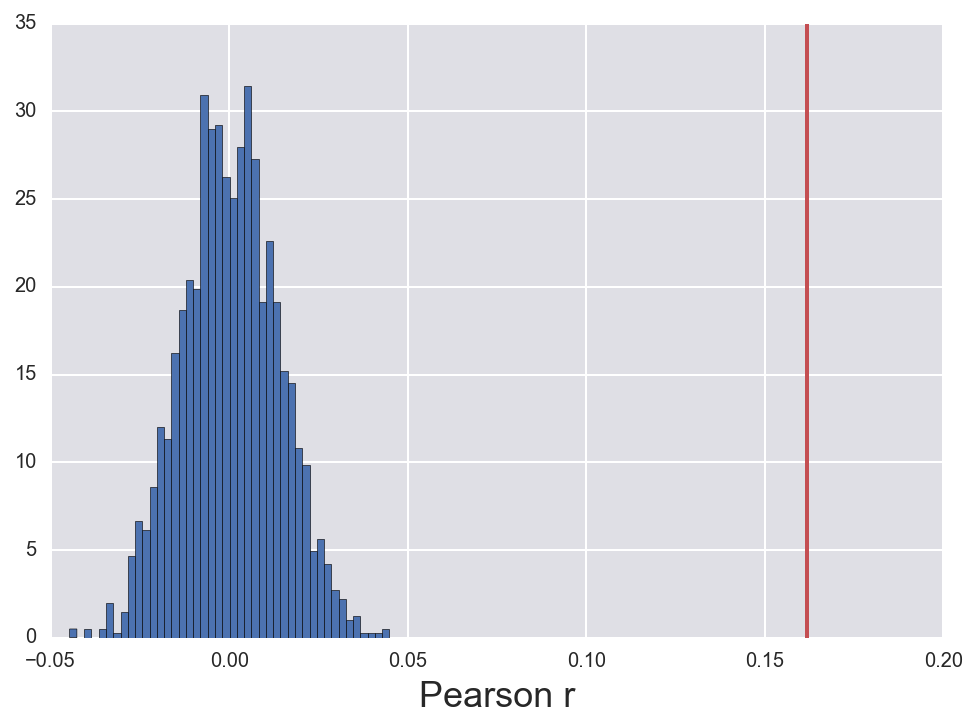

In [41]:
# Plot histogram
_ = plt.hist(r_scr, bins=int(np.sqrt(n_scramble)), normed=True)

# Plot computed r
plt.plot([r_unscr, r_unscr], plt.gca().get_ylim(), '-', 
         color=sns.color_palette()[2])

# Label axes
plt.xlabel('Pearson r')

We see that there is no way random pixels would give us the corrlelation coefficient we've measured in the unscrambled images.  But this doesn't seem to make any sense!  We saw in the eye test that these things are not colocalized.

The problem lies in the fact that we are considering background as well.  We have in a way proven that both Aubergine and Zucchini are located in cells.  We would like to see if they are colocalized *within* cells.  We therefore need to define an ROI to consider that is just cells.

### Defining an ROI for cells

We can do colocalization analysis after segmenting and defining an ROI.  For this purpose, we will do a simple thresholding technique.  Specifically, we will use Otsu's method to define a global threshold in both channels.  We will consider any pixel that has either the red or green channel above the respective threshold as part of the ROI.  We will also clean up and delete any small pieces of the image that are smaller than the width of the PSF.

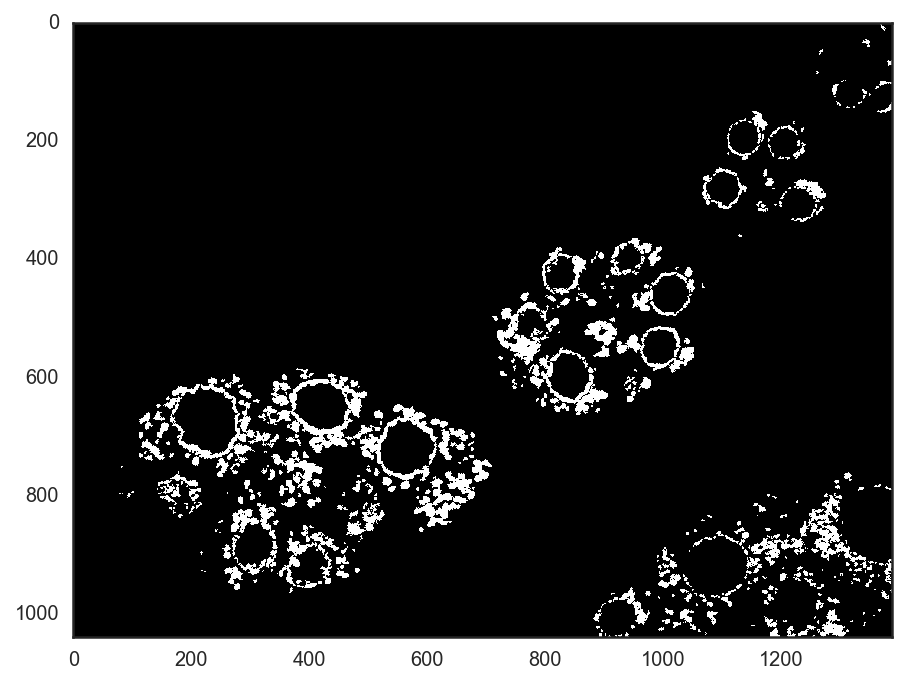

In [42]:
# Determine ROI by global thresholding using Yen's method
thresh_r = skimage.filters.threshold_otsu(im_r)
thresh_g = skimage.filters.threshold_otsu(im_g)

# Make ROI mask
roi = (im_r > thresh_r) | (im_g > thresh_g)
roi = skimage.morphology.remove_small_objects(roi, min_size=9)

# View the ROI
with sns.axes_style('white'):
    plt.imshow(roi, cmap=plt.cm.gray)

We still need to mirror the edges of the ROI so we can use it to make our new blocks based on this ROI.

In [43]:
# Make mirrored ROI
roi_mirror = bebi103.mirror_edges(roi, psf_width)

Let's look at what this did to the histogram.

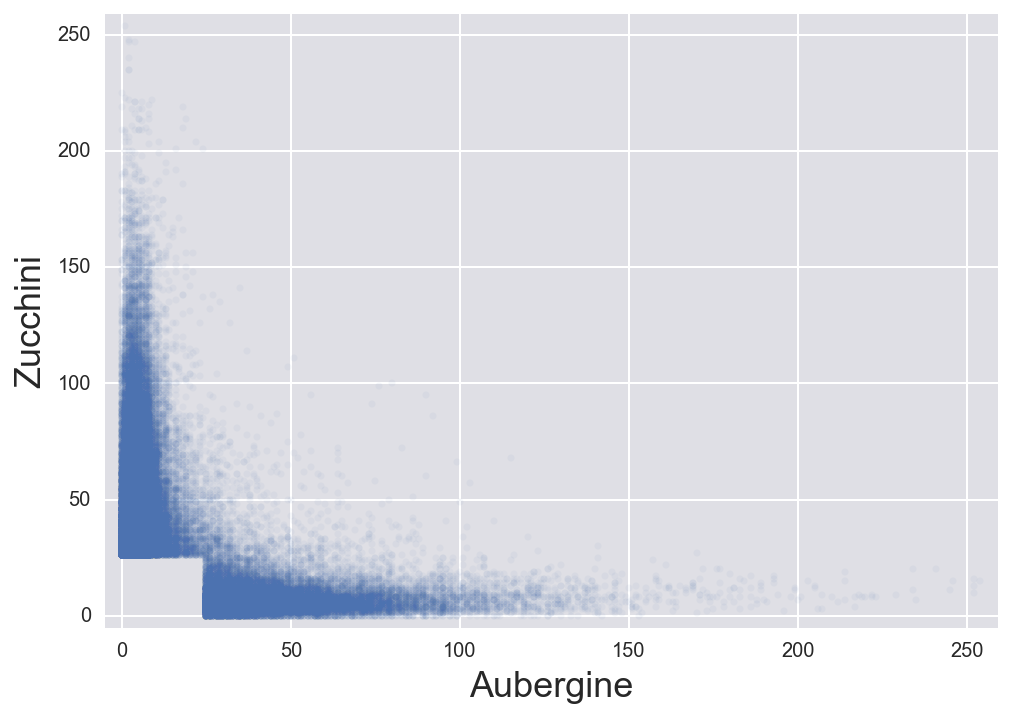

In [44]:
# Plot 2D histogram
plt.plot(im_r[roi].ravel(), im_g[roi].ravel(), '.', alpha=0.05)
plt.xlabel('Aubergine')
plt.ylabel('Zucchini')
plt.margins(0.02)

Let's redo the colocalization analysis using the ROI.

In [45]:
# Get blocks of red and green channels
blocks_r = bebi103.im_to_blocks(im_r_mirror, psf_width, roi=roi_mirror)
blocks_g = bebi103.im_to_blocks(im_g_mirror, psf_width, roi=roi_mirror)

# Store blocks as flattened array in case we don't want to scramble them
blocks_g_flat = np.array(blocks_g).flatten()

# Get r value for unscrambled images
r_unscr, _ = st.pearsonr(np.array(blocks_r).ravel(), blocks_g_flat)

# Do the scamblin'!
n_scramble = 2000
r_scr = scrambled_r(n_scramble, blocks_r, blocks_g_flat)

# Compute how sure we are that it's colocalized
p_coloc = (r_scr < r_unscr).sum() / n_scramble

# Print the values
print('unscrambled r =', r_unscr)
print('prob. of colocalization =', p_coloc)

unscrambled r = -0.585065240986
prob. of colocalization = 0.0


We see that those low intensity pixels (there were many of them) strongly biased our colocalization analysis.  In fact, Aubergine and Zucchini are definitely **not** colocalized!

## An example with colocalization

Let's now consider colocalization analysis with Aubergine and Krimper.

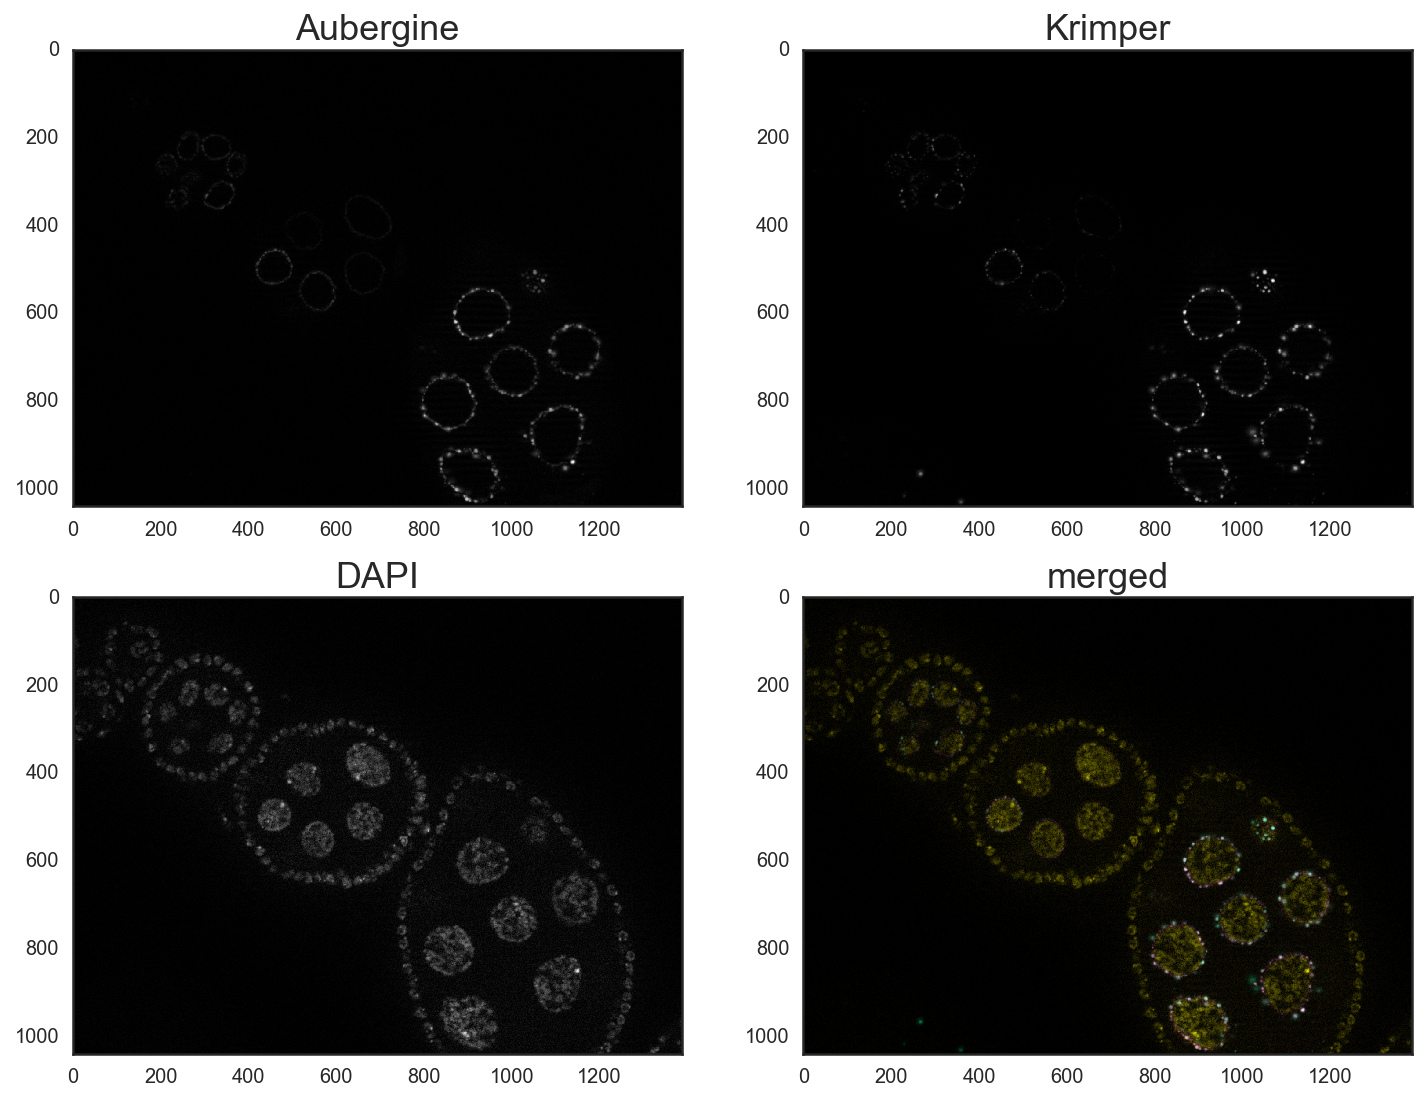

In [46]:
# Define file name
fname = os.path.join(data_dir, 'mk2-AubWTxGFP-Krimp_001_40x.TIF')

# Load the image
im = skimage.io.imread(fname)
    
# Channels of interest
im_r = im[:,:,0]
im_g = im[:,:,1]
im_b = im[:,:,2]

# Display the images
merged_image = bebi103.im_merge_cmy(im_g, im_r, im_b)

# Show the images
with sns.axes_style('white'):
    figure, ax = plt.subplots(2, 2, figsize=(12, 9))
    ax[0,0].imshow(im_r, cmap=plt.cm.gray)
    ax[0,1].imshow(im_g, cmap=plt.cm.gray)
    ax[1,0].imshow(im_b, cmap=plt.cm.gray)
    ax[1,1].imshow(merged_image)

    ax[0,0].set_title('Aubergine')
    ax[0,1].set_title('Krimper')
    ax[1,0].set_title('DAPI')
    ax[1,1].set_title('merged')

This one is more of a gray area.  When we do the "by eye" colocalization, we see some Aubergine puncta around the nuclei colocalized with Krimper, but not all.  Let's perform a quantitative Costes colocalization analysis.  Conveniently, I have written all colocalization the steps for you in the `bebi103.costes_coloc()` function!  We will not compute Manders coefficients now, but will discuss them later.  So, we just need to compute the ROI and then do the analysis.

In [47]:
# Compute ROI
thresh_r = skimage.filters.threshold_otsu(im_r)
thresh_g = skimage.filters.threshold_otsu(im_g)
roi = (im_r > thresh_r) | (im_g > thresh_g)
roi = skimage.morphology.remove_small_objects(roi, min_size=9)

# Use costes module to perform colocalization
coloc = bebi103.costes_coloc(im_r, im_g, n_scramble=n_scramble, psf_width=3,
                             do_manders=False, roi=roi, roi_method='all')

The results are stored in the `coloc` object.  We can see what is has using the `coloc.__dict__` attribute.  Note that many of the attributes are `None` since we haven't compute the Manders coefficients yet.

In [48]:
coloc.__dict__.keys()

dict_keys(['b', 'n_scramble', 'roi', 'psf_width', 'thresh_r', 'M_2', 'thresh_2', 'p_coloc', 'a', 'r_scr', 'roi_method', 'im_1', 'im_2', 'M_1', 'thresh_1', 'pearson_r'])

Let's check the probability of colocalization.

/Users/Justin/anaconda/lib/python3.4/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


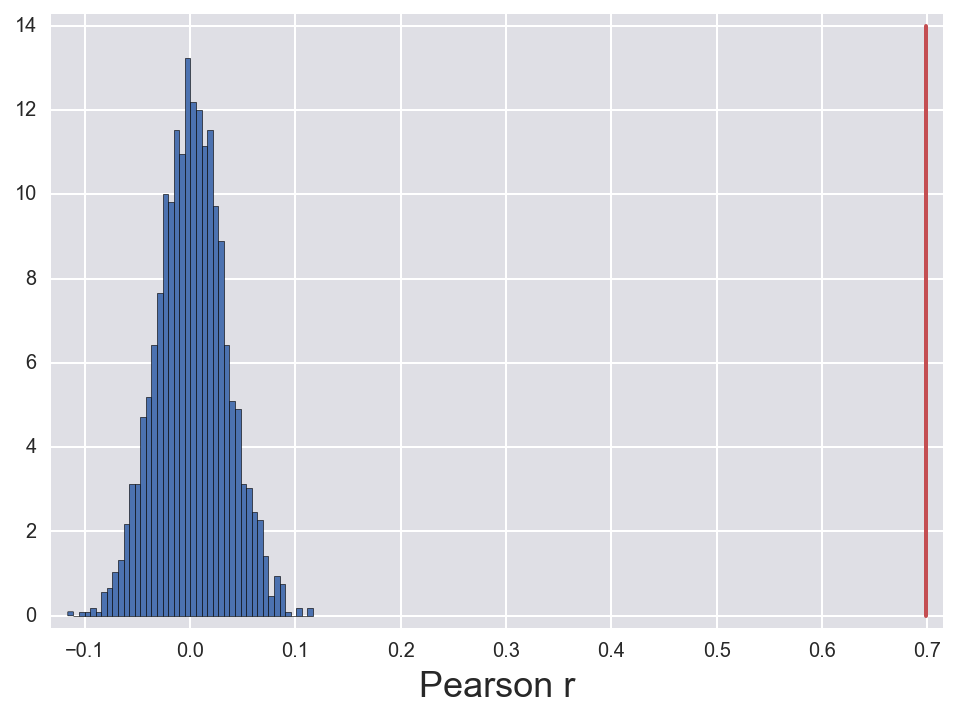

In [49]:
# Plot histogram
_ = plt.hist(coloc.r_scr, bins=int(np.sqrt(n_scramble)), normed=True)

# Plot computed r
plt.plot([coloc.pearson_r, coloc.pearson_r], plt.gca().get_ylim(), '-', 
        color=sns.color_palette()[2])

# Clean up
plt.xlabel('Pearson r')
plt.margins(0.02)

The Pearson $r$ is far beyond what we would get by random localization of pixels, so we are more or less 100% sure there is colocalization.

### Determining what pixels are colocated

The Costes method features an algorithm on how to specify which pixels are colocalized.  It goes as follows.  Let $I_g$ be the set of pixel intensities in the green channel and $I_r$ be the set of pixel intensities in the red channel.
1. Perform a regression based on all points of to give $I_g = a I_r + b$.
2. Define $T = \max(I_r)$.
3. Compute the Pearson $r$ value considering all pixels with $I_r < T$ and $I_g < aT + b$.
4. If $r \le r_\mathrm{thresh}$ (typically $r_\mathrm{thresh} = 0$), decrement $T$ and goto 3.  Otherwise, save $T_r = T$ and $T_g = aT + b$.
5. Pixels with $I_g > T_g$ and $I_r > T_r$ are colocalized.

The method then labels pixels with high intensity in both channels as colocalized.

### The Manders coefficients

The **Manders coefficient** is defined as the intensity-weighted fraction of pixels that are colocalized.

\begin{align}
M_r = \frac{\sum_{i_\mathrm{coloc}}I_{r,i}}{\sum_i I_{r,i}},
\end{align}

where the top sum is over colocalized pixels.  A similar definition applies for $M_g$. Note that $M_r \ne M_g$ in general.  E.g., imagine there are several red puncta in an image and a few green ones, but the green ones are always colocalized with the red.  Then, $M_g \approx 1$, but $M_r$ may be small.

The colocalized pixels are determined using Costes's method and then the Manders coefficients are computed using the `bebi103.costes_coloc()` function.

In [50]:
# Use costes module to perform colocalization
coloc = bebi103.costes_coloc(im_r, im_g, n_scramble=n_scramble, psf_width=3,
                             do_manders=True, roi=roi, roi_method='all')

# Print results
print("""
Pearson r = {0:.2f}
prob of colocalization = {1:.2f}
Manders coefficient for Aubergine = {2:.2f}
Manders coefficient for Krimper = {3:.2f}
""".format(coloc.pearson_r, coloc.p_coloc, coloc.M_1, coloc.M_2))


Pearson r = 0.70
prob of colocalization = 1.00
Manders coefficient for Aubergine = 0.49
Manders coefficient for Krimper = 0.53



Finally, we can view the colocalizated pixels in the merged image by setting their values to white.

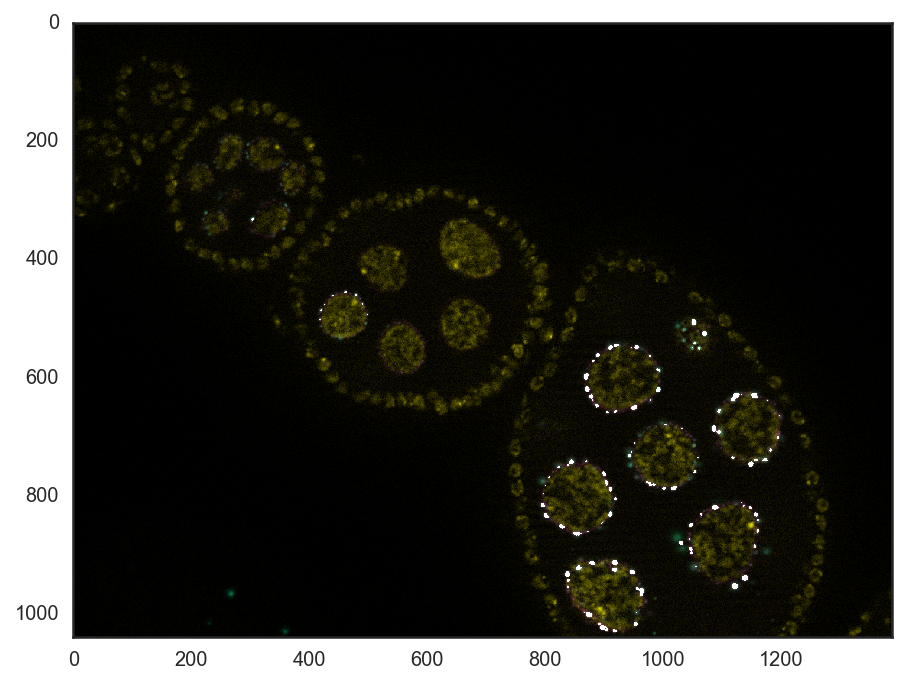

In [51]:
# Make merged image
merged_image = bebi103.im_merge_cmy(im_g, im_r, im_b)

# Inds that will be white
inds = (im_r > coloc.thresh_1) & (im_g > coloc.thresh_2)

# Convert inds to white
merged_image[inds,:] = 1.0

# Show the result
with sns.axes_style('white'):
    plt.imshow(merged_image)

Interestingly, when we plot the image this way, we can readily see that some of the Krimper puncta are colocalized and others are not.  It might be even easier to see if we exclude the DAPI channel.

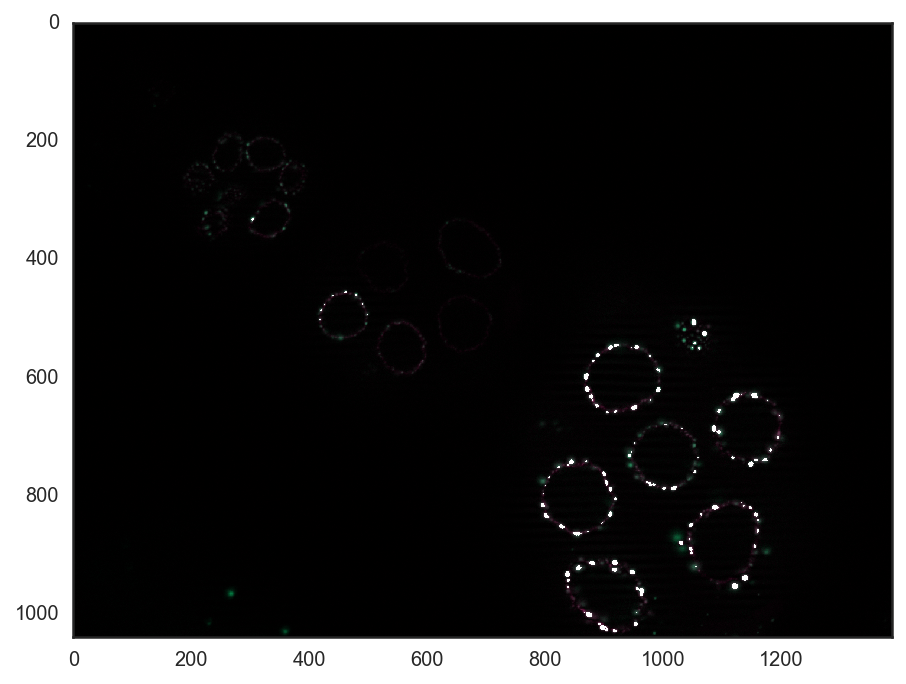

In [52]:
# Make merged image
merged_image = bebi103.im_merge_cmy(im_g, im_r, None)

# Inds that will be white
inds = (im_r > coloc.thresh_1) & (im_g > coloc.thresh_2)

# Convert inds to white
merged_image[inds,:] = 1.0

# Show the result
with sns.axes_style('white'):
    plt.imshow(merged_image)

Interestingly, at earlier stages of development, even though Aubergine is present, it is not colocalized with Krimper, but is at later stages.

## When we can't see it

As a final demonstration, we'll perform a colocalization analysis on images where we can't readily see the colocalization.

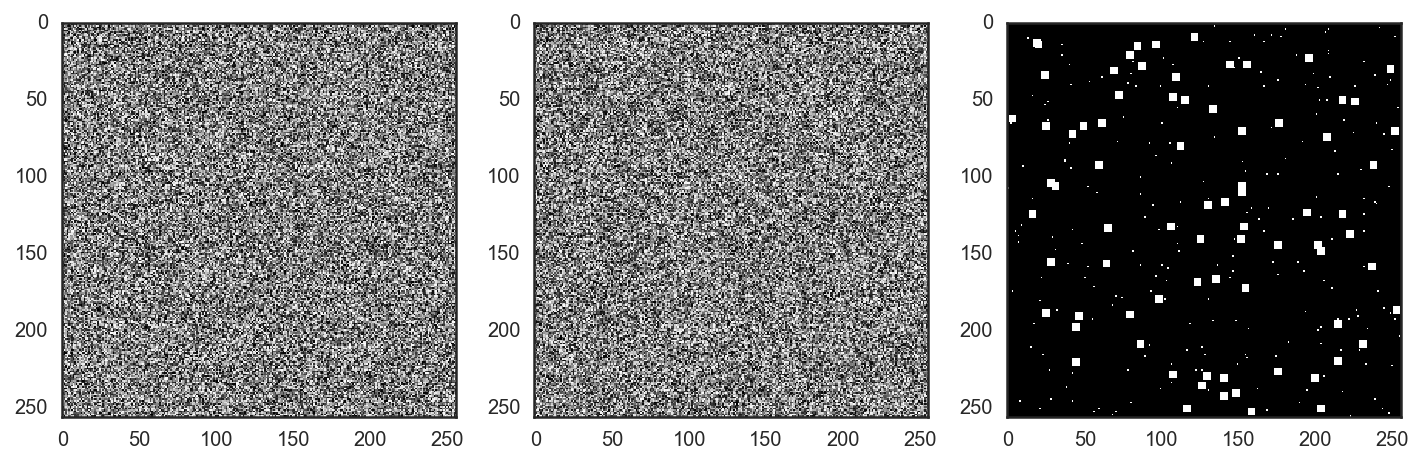

In [53]:
# Generate random images
im_1 = np.random.randint(0, 256, (256, 256))
im_2 = np.random.randint(0, 256, (256, 256))

# Make some pixels the same
psf_width = 5
n_same = int(0.03 * 256**2 / psf_width**2)
for i in range(n_same):
    i = np.random.randint(0, 256-psf_width)
    j = np.random.randint(0, 256-psf_width)
    subim = np.random.randint(0, 200, size=(psf_width, psf_width))
    im_1[i:i+psf_width, j:j+psf_width] = subim
    im_2[i:i+psf_width, j:j+psf_width] = subim

# Show images and regions where the signals are *exactly* colocated
with sns.axes_style('white'):
    figure, ax = plt.subplots(1, 3, figsize=(12, 8))
    ax[0].imshow(im_1, cmap=plt.cm.gray)
    ax[1].imshow(im_2, cmap=plt.cm.gray)
    ax[2].imshow(im_1==im_2, cmap=plt.cm.gray)

Hard to see by eye!  Let's compute the colocalization!

In [54]:
coloc = bebi103.costes_coloc(im_1, im_2, n_scramble=200, psf_width=5,
                               thresh_r=0.0, roi=None, do_manders=True)

# Print results
print("""
Pearson r = {0:.2f}
prob of colocalization = {1:.2f}
""".format(coloc.pearson_r, coloc.p_coloc))


Pearson r = 0.02
prob of colocalization = 1.00



Remember, the computer can often "see" better than we can!